# U-Net Baseline Model Improvements

In this notebook, we take the U-Net baseline model (as presented in tutorial 10) as a starting point and build upon it by introducing and evaluating one improvement after the other.

In [1]:
import os
from glob import glob

from src.utils import *
from src.models import UNet
from src.pytorch_utils import *
from src.dataset_augmentation import augment_dataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# get filenames of all the training samples from the original dataset
image_fns = sorted(glob(os.path.join("training", "images", "*.png")))
mask_fns = sorted(glob(os.path.join("training", "groundtruth", "*.png")))

### Original Configuration

Let us train the baseline model using the exact same configuration as shown during tutorial 10. This approach results in a F1 score of about 0.872 on the public Kaggle leaderboard.

In [ ]:
unet = UNet().to(device)
history = train_model(
    model=unet,
    image_fns_train=image_fns[:-10],
    mask_fns_train=mask_fns[:-10],
    image_fns_val=image_fns[-10:],
    mask_fns_val=mask_fns[-10:],
    n_epochs=35,
    batch_size=4,
)

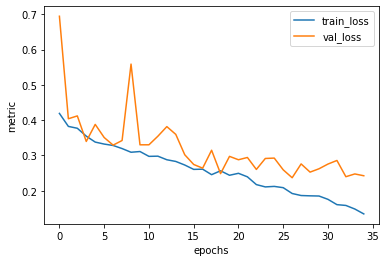

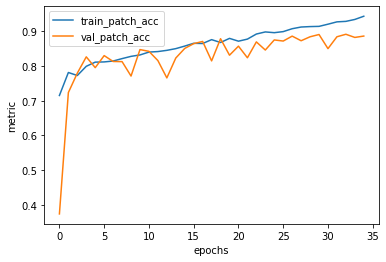

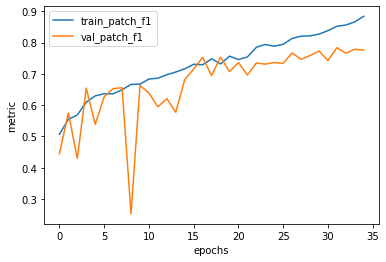

In [4]:
plot_training_history(history)

In [ ]:
preds = predict_on_test_set(unet, submission_fn="unet_baseline.csv")
plot_predictions(preds)

### Image Normalization.

Now, let us add image normalization as a preprocessing step. I.e. for each image, we compute the mean and std of each color channel and use them to normalize each channel. This addition results in a F1 score of about 0.883.

In [ ]:
unet = UNet().to(device)
history = train_model(
    model=unet,
    image_fns_train=image_fns[:-10],
    mask_fns_train=mask_fns[:-10],
    image_fns_val=image_fns[-10:],
    mask_fns_val=mask_fns[-10:],
    n_epochs=35,
    batch_size=4,
    normalize=True,
)

When comparing the training and validation metrics with the original history above, we can see that the model improves much faster now. Even when the training metrics start to diverge from the validation metrics (after epoch 15), patch accuracy and patch F1 score keep improving. Normalizing the input images clearly has a noticeable effect on the training, even though each U-Net block has a batch normalization layer.

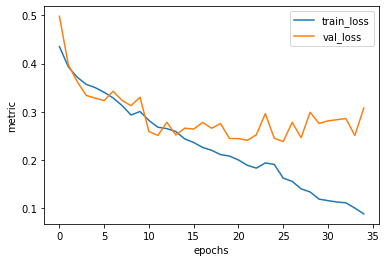

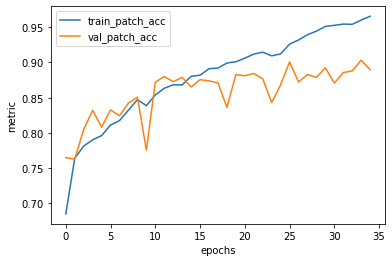

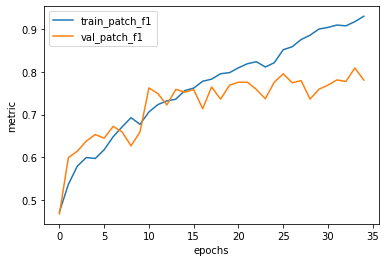

In [7]:
plot_training_history(history)

In [ ]:
preds = predict_on_test_set(unet, normalize=True, submission_fn="unet_baseline_image_norm.csv")
plot_predictions(preds)

### Weighted Loss
Since there are much more background pixels than road pixels in the segmentation masks (4.6x more in the training set), we can adjust the training loss such that positive labels (road) have a higher weight.

In [18]:
all_mask_pixels = load_images(os.path.join("training", "groundtruth"))

n_pos = np.count_nonzero(all_mask_pixels)
n_neg = all_mask_pixels.size - n_pos

print(f"Total number of pixels:\t\t{all_mask_pixels.size}")
print(f"Total number of pos. pixels:\t{n_pos}")
print(f"Total number of neg. pixels:\t{n_neg}")
print(f"#neg. / #pos. pixels:\t{float(n_neg) / n_pos}")

del all_mask_pixels

Total number of pixels:		23040000
Total number of pos. pixels:	4100589
Total number of neg. pixels:	18939411
#neg. / #pos. pixels:	4.618705020181247


In [ ]:
unet = UNet().to(device)
history = train_model(
    model=unet,
    image_fns_train=image_fns[:-10],
    mask_fns_train=mask_fns[:-10],
    image_fns_val=image_fns[-10:],
    mask_fns_val=mask_fns[-10:],
    n_epochs=35,
    batch_size=4,
    normalize=True,
    pos_weight=4.6,
)

Now, the loss of course has a different scale and needs to be interpreted differently. However, the weighted loss shows no clear advantage with respect to accuracy and F1 score.

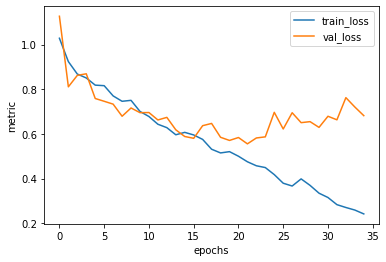

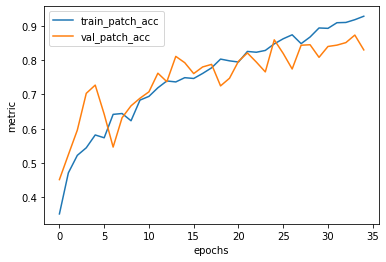

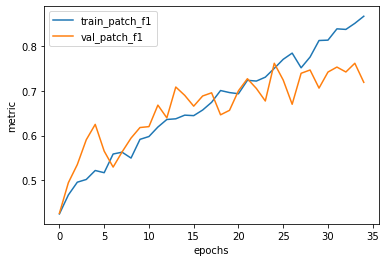

In [20]:
plot_training_history(history)

### Dataset Augmentation

Since we have very few training samples, we can create an extended dataset by applying random flips, rotations and color jitters. Please see *augmentation_experiments.ipynb* for more information. Let us generate 10 new samples from each original sample.

In [3]:
augment_dataset(
    imgs=load_pil_images(os.path.join("training", "images")), 
    masks=load_pil_images(os.path.join("training", "groundtruth")),
    n_samples_per_img=10,
    dir="training_ext",
    brightness=0.1, 
    contrast=0.1, 
    saturation=0.1, 
    hue=0.05
)

Image 1440/1440


Now, we have a dataset that is 10x larger! Let us retrain our baseline model on the extended dataset. Note that there is no information leakage in the following code cell. Since there are 10 versions of each original sample, we select the last 100 new samples for the validation set. This way, there are no two versions of the same original sample where one version is in the training set and the other one in the validation set.

In [ ]:
image_fns = sorted(glob(os.path.join("training_ext", "images", "*.png")))
mask_fns = sorted(glob(os.path.join("training_ext", "groundtruth", "*.png")))

unet = UNet().to(device)
history = train_model(
    model=unet,
    image_fns_train=image_fns[:-100],
    mask_fns_train=mask_fns[:-100],
    image_fns_val=image_fns[-100:],
    mask_fns_val=mask_fns[-100:],
    n_epochs=35,
    batch_size=4,
    normalize=True,
)

The training is much more robust now. If we plot the history of the metrics, we can see that patch accuracy and pach f1 score keep increasing, even though the model starts to overfit after epoch 15. Apparently, some "overconfidence" is beneficial in terms of patch accuracy and patch F1 score. If we use the model as trained to make predictions on the test set, we get a score of 0.897 on the leaderboard.

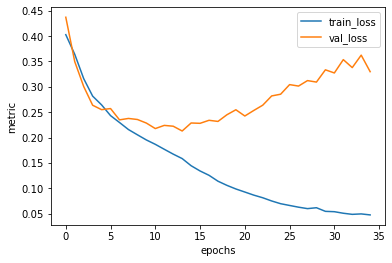

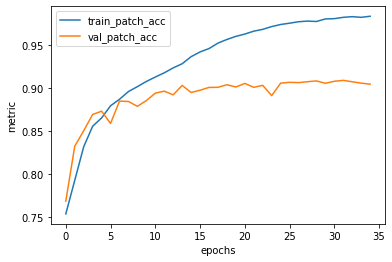

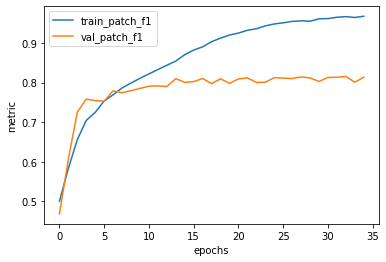

In [6]:
plot_training_history(history)

In [ ]:
preds = predict_on_test_set(unet, normalize=True, submission_fn="unet_baseline_augmentation.csv")
plot_predictions(preds)